In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Vroomie.zip을 /content/drive/MyDrive에 업로드 후 아래 코드 셀 실행

(drive 디렉터리는 위에 코드 셀 실행해서 마운트하면 나타남)



---



Vroomie 디렉터리로 이동하는 코드

In [ ]:
FOLDERNAME = 'Vroomie'
assert FOLDERNAME is not None, "[!] Enter the foldername."

import sys
sys.path.append('/content/drive/MyDrive/{}'.format(FOLDERNAME))

%cd /content/drive/MyDrive/$FOLDERNAME

/content/drive/MyDrive/Vroomie




---



Vroomie/data/ 디렉터리에 테스트 돌릴 파일 업로드 해놓고, 아래 video_path에 경로 적어서 테스트하시면 됩니다

In [ ]:
video_path = './data/driving_sample.mp4'
lane_detection(video_path)

NameError: name 'transforms' is not defined

**객체탐지 코드**

In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 119.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 94.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 55.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.1 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

In [ ]:
!mkdir -p yolov8_pretrained
!wget -O yolov8_pretrained/coco128.txt https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco128.yaml

--2025-05-09 12:36:13--  https://raw.githubusercontent.com/ultralytics/yolov5/master/data/coco128.yaml
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1912 (1.9K) [text/plain]
Saving to: ‘yolov8_pretrained/coco128.txt’

yolov8_pretrained/c 100%[===================>]   1.87K  --.-KB/s    in 0s      

2025-05-09 12:36:14 (8.02 MB/s) - ‘yolov8_pretrained/coco128.txt’ saved [1912/1912]



In [ ]:
!pip install deep-sort-realtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 82.8 MB/s eta 0:00:00


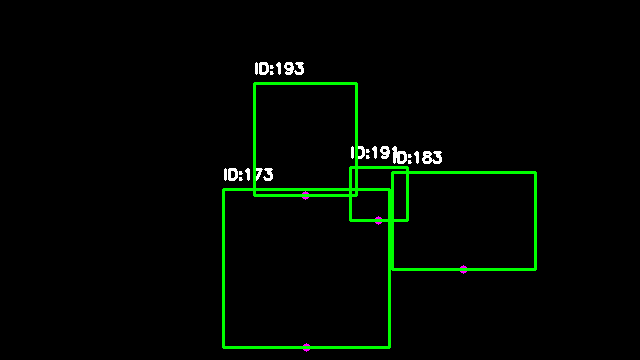

✅ 비디오 끝!
✅ 탐지 및 디버깅 종료!


In [ ]:
import math
import cv2
import os
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from ultralytics import YOLO
from deep_sort_realtime.deepsort_tracker import DeepSort
from model.lanenet.LaneNet import LaneNet
from google.colab.patches import cv2_imshow
from IPython.display import clear_output

import threading

# 설정값
CONFIDENCE_THRESHOLD = 0.65
FRAME_SKIP = 1
FRAME_RESIZE = (640, 360)
GREEN = (0, 255, 0)
WHITE = (255, 255, 255)
MAGENTA = (255, 0, 255)

# 클래스 목록
with open('./yolov8_pretrained/coco128.txt', 'r') as f:
    class_list = f.read().splitlines()

# 모델 로드
yolo_model = YOLO('./yolov8_pretrained/yolov8l.pt')
tracker = DeepSort(max_age=50, nms_max_overlap=0.5)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# LaneNet 세팅
resize_h, resize_w = 256, 512
data_transform = transforms.Compose([
    transforms.Resize((resize_h, resize_w)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
lanenet_model = LaneNet(arch='DeepLabv3+')
state_dict = torch.load('./log/best_model.pth', map_location=DEVICE)
lanenet_model.load_state_dict(state_dict)
lanenet_model.eval().to(DEVICE)

# 영상 로드
cap = cv2.VideoCapture('./data/sample1.mp4')
frame_count = 0

# 침범 감지 함수
def check_intrusion(track, binary, frame_size):
    x1, y1, x2, y2 = map(int, track.to_ltrb())
    w_frame, h_frame = frame_size
    fc = ((x1 + x2) // 2, y2)
    mx = int(fc[0] * (binary.shape[1] / w_frame))
    my = int(fc[1] * (binary.shape[0] / h_frame))
    mx, my = np.clip(mx, 0, binary.shape[1]-1), np.clip(my, 0, binary.shape[0]-1)
    pixel_val = binary[my, mx]
    on_lane = pixel_val > 128
    return on_lane, fc, (mx, my)

# 메인 루프
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("✅ 비디오 끝!")
        break

    if frame_count % FRAME_SKIP != 0:
        frame_count += 1
        continue

    frame = cv2.resize(frame, FRAME_RESIZE)
    h_frame, w_frame = FRAME_RESIZE[1], FRAME_RESIZE[0]

    # 객체 탐지 & 추적
    det = yolo_model.predict(source=[frame], save=False)[0]
    results = []
    for box in det.boxes.data.tolist():
        conf = float(box[4])
        if conf < CONFIDENCE_THRESHOLD:
            continue
        x1, y1, x2, y2 = map(int, box[:4])
        cls = int(box[5])
        results.append([[x1, y1, x2 - x1, y2 - y1], conf, cls])
    tracks = tracker.update_tracks(results, frame=frame)

    # 차선 인식
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    pil = Image.fromarray(rgb)
    inp = data_transform(pil).unsqueeze(0).to(DEVICE)
    out = lanenet_model(inp)
    binary = (out['binary_seg_pred'].squeeze().cpu().numpy() * 255).astype(np.uint8)

    # 침범 감지
    for track in tracks:
        if not track.is_confirmed():
            continue
        tid = track.track_id
        intrusion, fc, mask_pt = check_intrusion(track, binary, (w_frame, h_frame))
        if intrusion:
            print(f"🚨 침범 주의: 차량 ID {tid}")
        # 시각화
        cv2.circle(frame, fc, 4, MAGENTA, -1)
        cv2.rectangle(frame, (int(track.to_ltrb()[0]), int(track.to_ltrb()[1])),
                      (int(track.to_ltrb()[2]), int(track.to_ltrb()[3])), GREEN, 2)
        cv2.putText(frame, f"ID:{tid}", (int(track.to_ltrb()[0]), int(track.to_ltrb()[1]) - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, WHITE, 2)

    # 마스크 미니맵
    bin_color = cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)
    small = cv2.resize(bin_color, (160, 90))
    frame[0:90, -160:] = small

    # 출력
    clear_output(wait=True)
    cv2_imshow(frame)

    frame_count += 1

cap.release()
print("✅ 탐지 및 디버깅 종료!")


출력 결과는 lane_detection_pred에 (instance_pred, binary_pred) 튜플을 리스트로 넣어놨으니 이걸로 사용하시면 됩니다

우선 모델 테스트해보는 게 목적이니 일단 리스트로 넣어놨습니다

만약 실시간으로 차선+옆차끼어들기 까지 같이 돌려보고 싶으시면

```
lane_detection_pred.append((instance_pred, binary_pred))
```
이 부분을 지우고, 끼어들기 모델에 instance_pred, binary_pred를 바로 넣어서 돌려보시면 됩니닷

"이미지 결과 저장"은 테스트할때 결과 확인하기 쉽게 넣어놨는데, 파일저장도 시간이 나름 걸리는 작업이라 실제 테스트에선 삭제할 코드니 거슬리면 지우고 테스트하셔도 무방합니다.

<참고용>

**lane_detection_pred**

[(instance_pred0, binary_pred0), (instance_pred1, binary_pred1), (instance_pred2, binary_pred2), ...]

---

**instance_pred (차선별)**

```
array([[[254, 254, 254, ..., 254, 254, 253],
        [254, 254, 254, ..., 254, 254, 253],
        [254, 254, 254, ..., 254, 254, 253],
        ...,
        [252, 253, 254, ..., 254, 254, 254],
        [252, 253, 253, ..., 254, 254, 253],
        [251, 252, 253, ..., 254, 253, 253]],

       [[254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        ...,
        [254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254],
        [254, 254, 254, ..., 254, 254, 254]],

       [[  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        ...,
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0],
        [  0,   0,   0, ...,   0,   0,   0]]], dtype=uint8)
```

**binary_pred (차선 유무)**

```
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))
```